# Python Tasks
This notebook will demonstrate how to accomplish each of the tasks that Bob sent over as a starting point for working in the new Thrivent environment. They cover the following areas:
* Reading/Writing files - xlsx, csv
* Subsetting and merging data frames
* Adding calculated columns
* Basic statistics
* Plotting
* Modeling

### Load Packages

In [1]:
import pandas as pd # for data frames, reading and writing data
from matplotlib import pyplot as plt
from sklearn.decomposition import PCA
import psycopg2 # for connecting to a postgres database
import numpy as np # using this to create a range of floats
from math import sqrt

from scipy.stats import chi2_contingency, ks_2samp


# the next line is so that the matplot lib plots show up in the notebook cell
%matplotlib inline

## Load Data from a Database
We'll use some data from the Twitter work we've been doing for most of the analysis. I'll start by pulling data from our Postgres database on AWS. You cannot connect to this database without someone adding your IP address to the security group on AWS, but this will show you how to pull data from a database.

I'll pull 200 tweets from each topic to get a good mix. I'll pull each into a pandas DataFrame and merge them all together. Finally, I'll save them to Excel for the sample data for you to use. 

BEWARE - when pulling twitter ids (or any very large integers) into Excel, Excel tends to round them ton 15 places, losing 3 digits and making joins and merges break.

NOTE: I'm commenting all of this database stuff out, since you won't be able to connect anyway. Leaving the cells for my reference and yours, so you can see how database connections work with pandas.

In [2]:
# # Database Connection parapeters
# hostname = 'ditwitter.c6rgtnn1vfuu.us-east-1.rds.amazonaws.com'
# username = 'ditwitter_sa'
# pwd = 'ThriventTwitter'
# database = 'ditwitter'

# # Connect
# conn = psycopg2.connect( host=hostname, user=username, password=pwd, dbname=database )

In [3]:
# # First let's get a list of topics:
# SQL = """SELECT DISTINCT topics.* 
#         FROM topics
#         INNER JOIN models ON md_tp_id = tp_id"""

# topics_df = pd.read_sql(SQL, con=conn)
# topics_df

### Tweet Data

In [4]:
# # Create an empty data frame too hold the tweets we're going to collect
# tweets_df = pd.DataFrame()

# # Loop through all the active topics and grab a block of tweets, then merge with the tweets_df
# block_size = 200

# for tp_id in topics_df['tp_id']:
#     SQL = """SELECT t.*, tp_name 
#     FROM tweets t
#     INNER JOIN tweet_scores ts ON ts.ts_tweet_id = t.tweet_id
#     INNER JOIN models m ON m.md_id = ts.ts_md_id
#     INNER JOIN topics tp ON tp.tp_id = m.md_tp_id
#     WHERE tp_id = {}
#     LIMIT {}""".format(tp_id, block_size)
    
#     tweet_block = pd.read_sql(SQL, conn)
# #     print("pulled {} for topic_id: {}.".format(len(tweet_block), tp_id))
#     tweets_df = tweets_df.append(tweet_block)

# tweets_df.head()

### User Data
Let's pull the user data for all of these records. To do that, we'll need to build a "WHERE" clause that has all the unique user_ids from our tweets dataframe. We'll need to convert the values to strings, then separate them by commas. 

In [5]:
# # Build the list of user_ids
# sep = ','
# users_string = sep.join(tweets_df['user_id'].astype(str))

# SQL = "SELECT * FROM users WHERE id in ({})".format(users_string)
# users_df = pd.read_sql(SQL, conn)
# print(len(users_df))
# users_df.head()

## Save to Excel
Now that I've pulled the data for the examples, I'll save it to Excel for easy distribution. This is where we have to do something to get around the Excel string conversion issue. We don't care about tweet_ids, but we DO care about user_ids, since that's the field that we'll later join these two datasets on. To avoid the conversion issue, we'll add a column to the tweets_data that converts the user_id to string. We already have this column in the user data as `id_str`.

*NOTE: I've commented out the save-to-excel code, since I've since added other data to the sample_data.xlsx file that I don't want overwritten. Leaving it in here for reference.*

In [6]:
# tweets_df['user_id_str'] = tweets_df['user_id'].astype(str)

In [7]:
# Create a Pandas Excel writer using XlsxWriter as the engine.
# writer = pd.ExcelWriter('sample_data.xlsx', engine='xlsxwriter')

# # Write each dataframe to a different worksheet.
# tweets_df.to_excel(writer, sheet_name='tweet_data', index=False)
# users_df.to_excel(writer, sheet_name='user_data', index=False)
# writer.save()


### 0. Read Data from Excel
I'm using pandas to read in the data file from excel. If the file is located in the same directory as the notebook, this will work. Otherwise, add the path to the file to the filename. Pandas will automatically infer data types, column numbers and rownumbers from the data. There are quite a few different arguments that you can pass to this function to control what is loaded and how. The following cell will bring up the docstring for this function that has explanations for all of the options.

In [8]:
filename = 'sample_data.xlsx'
t_data = pd.read_excel(filename, sheet_name='tweets_classified')
t_data.head()

,text,class,topic
0,You remind me of my BimmerSee your ignition b...,0,Birth
1,RT @JaDineNATION: Were so excited for our dese...,0,Birth
2,i always get super self conscious about keepin...,0,Birth
3,@Juhhhhhhnelle Weird ass bitch lucky Im pregna...,1,Birth
4,RT @thdmichaelbell: New Signage above our Fron...,0,Birth


### 1. Export dataframe to tab delimited file
Now that we have some data to work with, we can export it to a tab-delimited file. After exporting, we'll remove the data frame and reload it from the csv file.
* setting the sep argument to '\t' makes it tab separated. Default is comma separated
* setting the index=False prevents it from writing out the row numbers as a column, creating an exraneous column.

In [9]:
export_filename = 'sample_data.csv'
t_data.to_csv(export_filename, sep='\t', index=False)
t_data = None

In [10]:
t_data = pd.read_csv(export_filename, sep='\t')
t_data.head()

,text,class,topic
0,You remind me of my BimmerSee your ignition b...,0,Birth
1,RT @JaDineNATION: Were so excited for our dese...,0,Birth
2,i always get super self conscious about keepin...,0,Birth
3,@Juhhhhhhnelle Weird ass bitch lucky Im pregna...,1,Birth
4,RT @thdmichaelbell: New Signage above our Fron...,0,Birth


Let's get an idea of what's in this dataframe - I know it has texts from different topics. Let's see how many from each are in there:

In [11]:
t_data['topic'].value_counts()

Marriage      241
Moving        240
Divorce       226
Graduation    226
Birth         199
Name: topic, dtype: int64

In [12]:
t_data['class'].value_counts()

0    883
1    206
2     43
Name: class, dtype: int64

Since we want the `class` variable to be binary, we have some data clean-up to do here. At some point I started using 2 for negatives, since it was easier on the keyboard than 0! Let's replace all of those 2s with 0 to make class truly binary.

In [13]:
t_data.loc[t_data['class']==2,'class'] = 0 
t_data['class'].value_counts()

0    926
1    206
Name: class, dtype: int64

In [14]:
# Check data types
t_data.dtypes

text     object
class     int64
topic    object
dtype: object

In [15]:
# Get some descriptive data from this dataframe
t_data.describe(include='all')

,text,class,topic
count,1132,1132.000000,1132
unique,1122,NaN,5
top,Two weeks exactly until Spring!! 😍🎉✨ We start ...,NaN,Marriage
freq,2,NaN,241
mean,NaN,0.181979,NaN
std,NaN,0.385998,NaN
min,NaN,0.000000,NaN
25%,NaN,0.000000,NaN
50%,NaN,0.000000,NaN
75%,NaN,0.000000,NaN


### Subsetting
Subsetting dataframes with Pandas is very similar to subsetting in R. Since the sample data has data from 5 different topics, let's pull out two topics and make them separate data frames.

Unlike R, when subsetting with Pandas you have to use `loc` or `iloc` before adding in the subset parameters. 
* `loc` is used when you have a criteria based on the values in a column or multiple columns
* `iloc` will give you the values from a numeric position in the dataframe. For example, if you wanted the first 10 rows of the data frame, you'd do the following:

*NOTE: Unlike R, Python is zero-based, so lists and indexes start at zero, rather than one.* 
#### Subsetting with `iloc`

In [16]:
# First 10 rows
t_data.iloc[0:10]

,text,class,topic
0,You remind me of my BimmerSee your ignition b...,0,Birth
1,RT @JaDineNATION: Were so excited for our dese...,0,Birth
2,i always get super self conscious about keepin...,0,Birth
3,@Juhhhhhhnelle Weird ass bitch lucky Im pregna...,1,Birth
4,RT @thdmichaelbell: New Signage above our Fron...,0,Birth
5,NEW SUPER BABY 2 SCAN AND TRANSLATION AND NEW ...,0,Birth
6,RT @Prof_Hariom: @OmarAbdullah Throw out of Bh...,0,Birth
7,RT @dre85567034: Mmm...Busty Preggos Yummy! Pa...,0,Birth
8,baby girl you re a star,0,Birth
9,RT @DDuaneOfficial: Glad I was able to speak w...,0,Birth


#### Subsetting with `loc`
When referencing columns in pandas, you can use either dataframe.column_name or dataframe['column name']. They should work the same way. Sometimes, maybe based on the column name itself, the .column_name doesn't work. ['column_name'] seems to be more reliable. In this dataframe, I had this issue with the 'class' column.

In [17]:
moving_df = t_data.loc[t_data.topic=='Moving']
moving_df.head()

,text,class,topic
892,Peaches is moving to the City where lots of ex...,0,Moving
893,The best thing we can realistically hope for i...,0,Moving
894,@Iam100Savage A Fund was moving out and hence ...,0,Moving
895,"You could win $4,000 towards a new home theate...",0,Moving
896,"If I wasn’t in a relationship, after graduatio...",0,Moving


In [18]:
marriage_df = t_data.loc[t_data['topic']=='Marriage']
marriage_df.head()

,text,class,topic
651,2 years ago i casually pinned wedding ideas da...,0,Marriage
652,so completely honored to stand next to this ma...,0,Marriage
653,the wedding chapel http://t.co/xthvajo4,0,Marriage
654,i love that my modern-day beauty &amp; the bea...,0,Marriage
655,on the train heading to pa for a friends weddi...,0,Marriage


#### Multiple subset criteria
This works the same way that subsetting in R does. Let's find all of the Marriage and Moving tweets where the Class==1. A common error when subsetting is: `The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().` If you get that, make sure you are using `&` and `|` for and/or operators. If it's still an issue, check parentheses - it seems like it needs more than necessary for the subset to work!

In [19]:
subset2 = t_data.loc[((t_data['topic']=='Marriage') & (t_data['class']==1)) |
                     ((t_data['topic']=='Moving') & (t_data['class']==1))]
subset2.head()

,text,class,topic
656,houston...i love you and i hate you right now....,1,Marriage
663,chaelisa for we got married,1,Marriage
664,here is how i feel about wedding thank you car...,1,Marriage
670,for all interested here is the video from our...,1,Marriage
682,thankful for an aunt who can do a few last min...,1,Marriage


### 2. Merging Data Frames
Now that we have two separate data frames for Marriage and Moving, let's merge them together and see if the number of class==1 matches our subset above. There are a lot of options when merging data frames - similar to joins with data tables. The [documentation](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.merge.html) is pretty helpful as is StackOverflow, of course.

This first example is just a combination of two dataframes... no index to match on. 

In [20]:
merged_df = marriage_df.merge(moving_df, how='outer')
print('Marrige data frame: {}'.format(len(marriage_df)))
print('Moving data frame: {}'.format(len(moving_df)))
print('Merged data frame: {}'.format(len(merged_df)))

Marrige data frame: 241
Moving data frame: 240
Merged data frame: 481


In [21]:
# Does our count of positive tweets match between the subset and the merged data?
len(subset2) == len(merged_df.loc[merged_df['class']==1])

True

We need some different data to show how to merge on different keys. Our sample file has data for this too in the `tweet_data` and `user_data` sheets.

In [22]:
tweet_df = pd.read_excel(filename, sheet_name='tweet_data')
tweet_df.head()

,tweet_id,id_str,created_at,text,user_id,favorite_count,favorited,in_reply_to_status_id,in_reply_to_user_id,lang,place,retweet_count,retweeted,tp_name,user_id_str
0,1025402184198967040,1025402184198967296,2018-08-03 15:25:06,RT @NdaliOzegbe: Imagine going to school grad...,327673809,0,False,NaN,NaN,en,NaN,0,False,Graduation,327673809
1,1025402408992734976,1025402408992735233,2018-08-03 15:26:00,RT @unclenick_00: IM KEEPING THIS SAME ENERGY ...,578247241,0,False,NaN,NaN,en,NaN,0,False,Graduation,578247241
2,1025402986762256000,1025402986762256384,2018-08-03 15:28:17,RT @dollyslibrary: If your little one is gradu...,108829376,0,False,NaN,NaN,en,NaN,0,False,Graduation,108829376
3,1025403397468561024,1025403397468561410,2018-08-03 15:29:55,#IRememberATime when I thought graduating coll...,1016737236497457024,0,False,NaN,NaN,en,NaN,0,False,Graduation,1016737236497457152
4,1025403499750859008,1025403499750858757,2018-08-03 15:30:20,Class of 2017 have you secured your spot on y...,895222808707551232,0,False,NaN,NaN,en,NaN,0,False,Graduation,895222808707551232


In [23]:
user_df = pd.read_excel(filename, sheet_name='user_data')
user_df.head()

,id,id_str,name,screen_name,location,followers_count,friends_count,favourites_count,description,geo_enabled,...,statuses_count,time_zone,created_at,verified,utc_offset,contributors_enabled,listed_count,protected,url,state
0,8192222,8192222,Jezebel,Jezebel,NaN,318516,29,94,All the news you need. Without airbrushing.,0,...,81056,Eastern Time (US & Canada),2007-08-14 22:57:34,1,-14400.0,0,6709,0,http://jezebel.com,NaN
1,11801852,11801852,Jenna Hatfield,JennaHatfield,Cambridge OH,10024,6808,21156,Award winning writer. Editor. Wife. Mom. Dog l...,0,...,106425,Eastern Time (US & Canada),2008-01-03 15:51:49,0,-14400.0,0,577,0,http://stopdropandblog.com,Ohio
2,12366342,12366342,King County Library,KCLS,King County WA,10442,235,4417,King County Library System (KCLS) is your comm...,1,...,17786,Pacific Time (US & Canada),2008-01-17 17:51:28,0,-28800.0,0,548,0,http://www.kcls.org,Washington
3,14362996,14362996,Alanna Banks,fridaysoffshop,Toronto,765,850,32,Shop Owner at fridaysoff.ca an online source o...,0,...,1946,Quito,2008-04-11 17:49:07,0,-18000.0,0,48,0,http://fridaysoff.ca,NaN
4,15430687,15430687,C.B. Cebulski,CBCebulski,Shanghai China,55961,869,11642,Just a guy lucky enough to work for Marvel. Tr...,0,...,22157,Eastern Time (US & Canada),2008-07-14 19:04:35,1,-14400.0,0,1889,0,http://www.eataku.tumblr.com,NaN


Now that we have a handful of tweets, we want to merge the tweet data with the user data to append specific user columns to the tweet data. Let's only grab a few columns from each data frame to keep it easy to read. We can select a subset of columns with no other criteria with `dataframe[[list of columns]]`.

The `how` parameter of the merge works like a join, defining what rows to keep when there isn't a match in both dataframes. It defaults to an inner join. In this case I want to keep all of the tweets, even if we don't have a user record, so I'm using `how=left` since the first table in the merge (the left one) is the tweet_df.

NOTE: join on tweet_df.user_id_str = user_df.id_str, to avoid any truncation of the long integers that may have happend in exporting to Excel!

### 2. (cont): Merge using a unique match key.

In [24]:
merged_tweets = tweet_df[['tweet_id', 'created_at', 'user_id_str', 'text']].merge(
    user_df[['id_str', 'name','screen_name', 'followers_count']],
    left_on='user_id_str',
    right_on='id_str',
    how='left')

merged_tweets.head()

,tweet_id,created_at,user_id_str,text,id_str,name,screen_name,followers_count
0,1025402184198967040,2018-08-03 15:25:06,327673809,RT @NdaliOzegbe: Imagine going to school grad...,327673809,Ya Girl,bellabiceps,1019
1,1025402408992734976,2018-08-03 15:26:00,578247241,RT @unclenick_00: IM KEEPING THIS SAME ENERGY ...,578247241,Big Tit Energy,theCoolestLame3,6889
2,1025402986762256000,2018-08-03 15:28:17,108829376,RT @dollyslibrary: If your little one is gradu...,108829376,Kat Dickinson,DickinsonKat,76
3,1025403397468561024,2018-08-03 15:29:55,1016737236497457152,#IRememberATime when I thought graduating coll...,1016737236497457152,kandidklerity,kandidklerity,2
4,1025403499750859008,2018-08-03 15:30:20,895222808707551232,Class of 2017 have you secured your spot on y...,895222808707551232,VDS Training,trainingVDS,639


### 3. Bin a continuous variable into a new variable.
Since we have a bunch of users, let's bin their followers_count into equal width bins. This was a new one for me, but there is a handy pandas function for it, similar to R, called [pandas.cut](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.cut.html)

In [25]:
merged_tweets['binned_followers'] = pd.cut(merged_tweets['followers_count'], bins=5, labels = ['very_low',
                                                                                               'low',
                                                                                               'medium',
                                                                                               'high',
                                                                                              'very_high'])
merged_tweets['binned_followers'].value_counts()

very_low     794
very_high      2
high           2
low            2
medium         0
Name: binned_followers, dtype: int64

### 4. Binning with an equal number of members
Cutting the followers_count into equal sized bins wasn't very helpful, since there are two users with so many followers that the ranges become unuseful.  

More useful may be to use quartiles. For that, we'll have to calculate the quartiles ahead of time, then pass them into the `cut` function as the `squence of scalars`.

In [26]:
bins = 5
# use pandas.quantile function and np.linspace to generate the cutoff values for the cut-function.
cutoffs = list(merged_tweets['followers_count'].quantile(np.linspace(0,1,bins+1)))

# create some labels for our new, binned column
labels = ['Q'+str(x) for x in range(1,bins+1)]

# cut the data based on the cutoffs
merged_tweets['quartile_followers'] = pd.cut(merged_tweets['followers_count'], cutoffs, labels = labels)

# check if it worked
merged_tweets['quartile_followers'].value_counts()

Q5    160
Q4    160
Q3    160
Q2    159
Q1    157
Name: quartile_followers, dtype: int64

Let's see how that worked out. We'll look at the mean, median and median and standard deviation for each quartile of follower_counts. We can use the groupby function in pandas to get these aggregates.

In [27]:
merged_tweets.groupby('quartile_followers')['followers_count'].agg(['mean', 'median', 'std'])

,mean,median,std
quartile_followers,,,
Q1,48.624204,46.0,31.561380
Q2,213.628931,206.0,67.487416
Q3,499.087500,491.5,99.045786
Q4,978.850000,924.5,232.875225
Q5,15506.737500,2819.0,45246.019754


### Macro variable for data selection
From Corinne: *In SAS we frequently create a list of variables by putting them in a macro variable that we use for data exploration and variable selection so that we can perform the necessary tasks for all variables easily.*

Using the user_df data frame, let's pick a subset of data for our macro variable. The macro variable will be a list with the column names we want.

In [28]:
# Show the list of all columns
list(user_df.columns)

['id',
 'id_str',
 'name',
 'screen_name',
 'location',
 'followers_count',
 'friends_count',
 'favourites_count',
 'description',
 'geo_enabled',
 'lang',
 'statuses_count',
 'time_zone',
 'created_at',
 'verified',
 'utc_offset',
 'contributors_enabled',
 'listed_count',
 'protected',
 'url',
 'state']

In [29]:
# Create our subset variable - let's pick all the numerical fields
col_subset = [
    'followers_count',
    'friends_count',
    'favourites_count',
    'statuses_count',
    'listed_count']

# Now we can use this variable to select from the data:
user_df[col_subset].head()

,followers_count,friends_count,favourites_count,statuses_count,listed_count
0,318516,29,94,81056,6709
1,10024,6808,21156,106425,577
2,10442,235,4417,17786,548
3,765,850,32,1946,48
4,55961,869,11642,22157,1889


### 5. Create a two way frequency table
Back to our classified tweet data, we have different topics (multiple) and we have classification (binary). We can create a two-way frequency table showing the number of each class in each topic. We can use panads.crosstab to get to this result.

In [30]:
two_way = pd.crosstab(t_data['topic'],t_data['class'])
two_way

class,0,1
topic,,
Birth,172,27
Divorce,213,13
Graduation,149,77
Marriage,196,45
Moving,196,44


You can also use the pivot_table function to get to the same results.

In [31]:
two_way_pivot = t_data.pivot_table(index='topic', columns = 'class', aggfunc=len)

Both of these results have a multi-part index, making it a little complicated to subset the results. Since it has a multiple index, you have to pass values or criteria for both components of the index.

In [32]:
two_way.loc[(['Marriage','Moving'],[0,1])]

class,0,1
topic,,
Marriage,196,45
Moving,196,44


In [33]:
two_way_pivot.loc[['Marriage','Moving']]

text    
class       0   1
topic            
Marriage  196  45
Moving    196  44

This pivot approach seems to be more difficult to subset, as doesn't like my second part of the index.

### Chi-Squared independence test, statistic and p-value
[Scipy](https://docs.scipy.org/doc/scipy-0.15.1/reference/generated/scipy.stats.chi2_contingency.html) has a good function for this. We can subset the crosstab to only grab the 0 and 1 columns and use that as our contingency table. The results from this function are, in order:
* chi2 : float, The test statistic.
* p : float, The p-value of the test
* dof : int, Degrees of freedom
* expected : ndarray, same shape as observed, The expected frequencies, based on the marginal sums of the table.

In [34]:
chi2 = chi2_contingency(two_way[[0,1]])

In [35]:
chi2

(64.6713594960832,
 3.0178804528059226e-13,
 4,
 array([[162.78621908,  36.21378092],
        [184.87279152,  41.12720848],
        [184.87279152,  41.12720848],
        [197.14310954,  43.85689046],
        [196.32508834,  43.67491166]]))

### 6. How to generate a summary of interval/continuous/numeric variables including
* Basic statistics like the mean, median, percentiles, standard deviation, etc.
* Confidence intervals around the mean

A quick way to get to some of this information is with the `describe` function on a dataframe. By default, this will only describe numeric variables:

In [36]:
merged_tweets.describe()

,tweet_id,user_id_str,id_str,followers_count
count,8.000000e+02,8.000000e+02,8.000000e+02,800.000000
mean,1.002401e+18,2.188585e+17,2.188585e+17,3448.936250
std,2.526354e+16,3.834958e+17,3.834958e+17,21068.881171
min,9.712287e+17,8.192222e+06,8.192222e+06,0.000000
25%,9.721836e+17,3.141865e+08,3.141865e+08,156.250000
50%,1.015113e+18,1.467469e+09,1.467469e+09,491.500000
75%,1.025432e+18,4.914693e+09,4.914693e+09,1134.500000
max,1.026743e+18,1.026092e+18,1.026092e+18,318516.000000


If we add `include='all'` we'll get descriptive date on the rest of the columns, with a bunch of 'NaN' for irrelevant statistics.

In [37]:
merged_tweets.describe(include='all')

,tweet_id,created_at,user_id_str,text,id_str,name,screen_name,followers_count,binned_followers,quartile_followers
count,8.000000e+02,800,8.000000e+02,800,8.000000e+02,782,800,800.000000,800,796
unique,NaN,704,NaN,699,NaN,689,724,NaN,4,5
top,NaN,2018-08-03 15:52:45,NaN,RT @MooseWD: Quick update from me: I found the...,NaN,,trinityhercules,NaN,very_low,Q5
freq,NaN,4,NaN,8,NaN,7,2,NaN,794,160
first,NaN,2018-03-07 03:39:12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
last,NaN,2018-08-07 08:13:59,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,1.002401e+18,NaN,2.188585e+17,NaN,2.188585e+17,NaN,NaN,3448.936250,NaN,NaN
std,2.526354e+16,NaN,3.834958e+17,NaN,3.834958e+17,NaN,NaN,21068.881171,NaN,NaN
min,9.712287e+17,NaN,8.192222e+06,NaN,8.192222e+06,NaN,NaN,0.000000,NaN,NaN
25%,9.721836e+17,NaN,3.141865e+08,NaN,3.141865e+08,NaN,NaN,156.250000,NaN,NaN


Since this gives you the standard deviation for numeric fields, you can use that to create confidence intervals as needed. Here's how you can pull values out of this function - let's say we want the standard deviation for the followers_count:

In [38]:
# set the description to a data frame variable, then pull the value as a subset
desc = merged_tweets.describe(include='all')
desc.loc['std','followers_count']

21068.88117115957

In [39]:
# or call the function and pull the value directly from the results, if there's no other need for that data.
merged_tweets.describe().loc['std','followers_count']

21068.88117115957

In [40]:
# Double checking that it's right using the standard deviation function (std)
merged_tweets['followers_count'].std()

21068.88117115957

### 7. How to generate a Kolmogorov-Smirnov test for difference between cumulative distribution functions
* Given an interval/continuous/numeric variable and a binary (target) variable 
* Compare the empirical cumulative distributions between the two values of the binary variable
* Including the K-S maximum separation, and p-value

Here is the [scipy](https://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.stats.ks_2samp.html) documentation for their 2-sample KS test.

#### Binary Variable
For our binary variable, let's create a variable in our user data that's US (yes or no) by gathering up all of the US timezones. Then we'll look at the KS test comparing followers counts to see if East Coasters have more followers than non-East Coasters.

In [41]:
# Gathering US timezones from the data:
us_timezones = ['Pacific Time (US & Canada)',
                'Central Time (US & Canada)',
                'Eastern Time (US & Canada)',
                'Mountain Time (US & Canada)',
               'Arizona',
               'America/Los_Angeles',
               'Indiana (East)',
               'Alaska',
                'America/New_York']

# Split the data into two samples
sample_1 = user_df.loc[user_df.time_zone.isin(us_timezones), 'followers_count']
sample_2 = user_df.loc[~user_df.time_zone.isin(us_timezones), 'followers_count']

#Check the sizes of the two samples:
print('N1 = {} \nN2 = {}'.format(len(sample_1), len(sample_2)))

N1 = 89 
N2 = 635


In [42]:
ks_2samp(sample_1, sample_2)

Ks_2sampResult(statistic=0.09441741130673276, pvalue=0.47035384741490055)

Since the null-hypothesis of this test is that they from the same distribution. With this large p-value, we cannot reject the null-hypothesis and the differences between the two distributions are not statistically significant.

### 2-Sample KS Plot
Let's make the typical cumulative distribution plot for these two samples to see if the KS results seem reasonable.

In [43]:
n1 = len(sample_1)
n2 = len(sample_2)

cdf1 = [x/n1 for x in range(0,n1)]
cdf2 = [x/n2 for x in range(0,n2)]

Text(0.5,1,'2-Sample KS Plot')

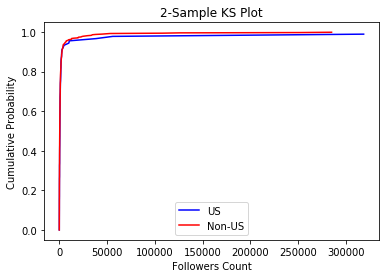

In [44]:
# plt.figure(figsize = (10,5))
plt.plot(sample_1.sort_values().tolist(), cdf1, lw=1.5, label = 'US', color='blue')
plt.plot(sample_2.sort_values().tolist(), cdf2, lw=1.5, label = 'Non-US', color='red')

plt.legend( loc = 8) 
plt.axis('tight') 
plt.xlabel('Followers Count') 
plt.ylabel('Cumulative Probability') 
plt.title('2-Sample KS Plot') 

This plot is a little ridiculous looking because of some large outliers. Let's look again for users under a cutoff value.

In [45]:
cutoff = 5000

# Split the data into two samples
sample_1a = user_df.loc[(user_df.time_zone.isin(us_timezones)) & (user_df.followers_count < cutoff), 'followers_count']
sample_2a = user_df.loc[(~user_df.time_zone.isin(us_timezones)) & (user_df.followers_count < cutoff), 'followers_count']

#Check the sizes of the two samples:
print('N1a = {} \nN2a = {}'.format(len(sample_1a), len(sample_2a)))

N1a = 84 
N2a = 597


In [46]:
ks_2samp(sample_1a, sample_2a)

Ks_2sampResult(statistic=0.1018186168939938, pvalue=0.41055957117237946)

Still getting a very small test-statistic and large p-value, so we cannot conclude that they are from different distributions.

Text(0.5,1,'2-Sample KS Plot - Under 5000 Followers')

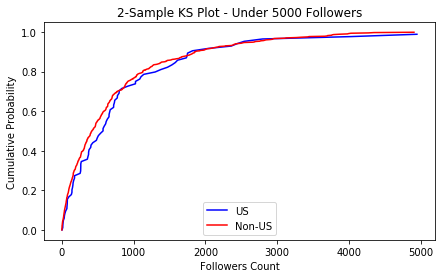

In [47]:
n1a = len(sample_1a)
n2a = len(sample_2a)

cdf1a = [x/n1a for x in range(0,n1a)]
cdf2a = [x/n2a for x in range(0,n2a)]

# Remake the plot
plt.figure(figsize = (7,4))
plt.plot(sample_1a.sort_values().tolist(), cdf1a, lw=1.5, label = 'US', color='blue')
plt.plot(sample_2a.sort_values().tolist(), cdf2a, lw=1.5, label = 'Non-US', color='red')

plt.legend( loc = 8) 
plt.axis('tight') 
plt.xlabel('Followers Count') 
plt.ylabel('Cumulative Probability') 
plt.title('2-Sample KS Plot - Under {} Followers'.format(cutoff)) 

### 8. How to create a bar chart for a categorical variable versus a binary variable
* The categories of the categorical variable along the vertical axis
* The mean/percentage of the binary variable (1 values) along the horizontal axis
* Confidence intervals at the ends of the bars

### General plotting
We can use matplotlib for all of our plotting needs. It is pretty much the Python counterpart to ggplot2. We showed the hooks from pandas into matplotlib above. Here's how plots can be built and customized using matplotlib directly.

We'll use the tweet data (`t_data`) with all topics and classes for starters.

In [48]:
plot_data = t_data.groupby(['topic'])['class'].agg(['mean', 'std', 'count'])
plot_data['sqr_count'] = [sqrt(x) for x in plot_data['count']]
plot_data['SE'] = plot_data['std']/plot_data['sqr_count']
del(plot_data['sqr_count'])
plot_data.sort_values('mean', inplace=True)
plot_data

,mean,std,count,SE
topic,,,,
Divorce,0.057522,0.233354,226,0.015523
Birth,0.135678,0.343310,199,0.024337
Moving,0.183333,0.387748,240,0.025029
Marriage,0.186722,0.390499,241,0.025154
Graduation,0.340708,0.474999,226,0.031596


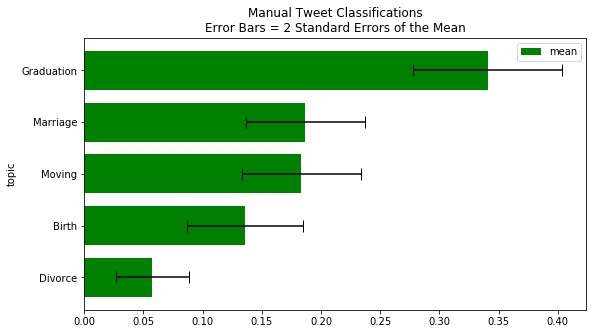

In [49]:
# Plot horizontal bar using pandas including error bars
error = 2*plot_data['SE']
plot_data[['mean']].plot.barh(width=.75, 
                              color='green', 
                              figsize=(9,5),
                              xerr=error,
                              capsize=6,
                             title='Manual Tweet Classifications\nError Bars = 2 Standard Errors of the Mean')

Plotting again, but with points for the means and error bars.

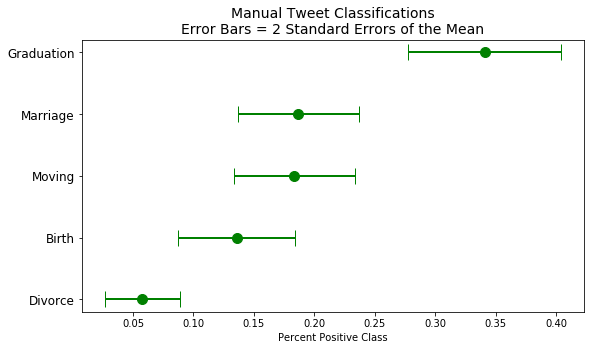

In [50]:
# Plot again using Matplotlib directly
# define the location on the y axis - based on the number of topics
fig, ax = plt.subplots(figsize=(9,5))
y_pos = np.arange(len(plot_data))
class_avg = plot_data['mean']
error = 2*plot_data['SE']

ax.errorbar(class_avg, 
            y_pos,
            xerr=error, 
            capsize = 8,
            fmt='o', 
            markersize=10, 
            linewidth=2, 
            color='green')
ax.set_yticks(y_pos)
ax.set_yticklabels(plot_data.index, size=12)
# ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('Percent Positive Class')
ax.set_title('Manual Tweet Classifications\nError Bars = 2 Standard Errors of the Mean', size=14)

plt.show()

### 9. PCA on a collection of interval/continuous/numeric variables
[Scikit-Learn PCA example](http://scikit-learn.org/stable/auto_examples/decomposition/plot_pca_iris.html)

Since the Twitter data we've been working with so far doesn't have a good number of correlated covariates, we'll load some data from "Statistical Sleuth" for the PCA example. You'll find this data in the "pca" sheet of our sample data. These data are measurements related to the magnetic force on rods in printers. There are three factors, or variables:
* electric current (0, 250, 500)
* component configuration (0 or 1)
* type of metal (1,2,3,4)

In [51]:
pca_data = pd.read_excel(filename, sheet_name='pca')
pca_data.head()

,L1,L2,L3,L4,L5,L6,L7,L8,L9,L10,L11,CURRENT,CONFIGUR,MATERIAL
0,136,142,139,131,122,118,134,138,148,149,171,0,0,1
1,639,723,782,756,804,804,909,962,1042,1058,1022,250,0,1
2,673,709,709,719,682,681,759,912,1122,1121,900,500,0,1
3,471,501,521,519,528,521,540,523,548,525,513,0,1,2
4,578,617,650,625,632,634,677,695,733,735,747,250,1,2


Let's start by looking at the first five principal components with the 11 rod measurement locations. (note -using '.iloc' since we're picking columns by column number):

In [52]:
pca = PCA(n_components=5)
pca.fit(pca_data.iloc[:,0:11])

PCA(copy=True, iterated_power='auto', n_components=5, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [53]:
# Throwing the components into a dataframe for easier viewing:
pd.DataFrame(pca.components_)

,0,1,2,3,4,5,6,7,8,9,10
0,-0.222751,-0.232678,-0.238950,-0.248596,-0.262664,-0.290082,-0.309476,-0.336031,-0.376914,-0.379191,-0.360089
1,0.303992,0.265199,0.259525,0.263796,0.306771,0.387665,0.083217,-0.178518,-0.369690,-0.404456,-0.341871
2,-0.258881,-0.269982,-0.291085,-0.292707,-0.067155,0.791077,0.200734,-0.078153,-0.054788,-0.000496,0.099825
3,0.092358,0.050182,0.008377,-0.021469,-0.127594,0.209102,-0.259608,-0.089107,0.430717,0.394391,-0.715555
4,-0.727500,-0.203342,0.333492,0.144541,0.366972,-0.102910,0.222125,0.134684,0.075304,-0.039724,-0.278029


In [54]:
# This part of the outputs shows how much of the variance is captured in each principal component:
list(pca.explained_variance_ratio_)

[0.9646030884971594,
 0.02571518940850387,
 0.006983807971060033,
 0.001353086110446999,
 0.0006707852055051018]

In [55]:
pca.explained_variance_ratio_

array([9.64603088e-01, 2.57151894e-02, 6.98380797e-03, 1.35308611e-03,
       6.70785206e-04])